# FIN Model

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D

In [2]:
random.seed(222)
# Will use Mean for training, so calculate the Mean of the data
def Mean(data):
    return np.mean(data,axis=1)

def STD(data):
    return np.std(data,axis=1)

Topology Configuration:

configurate the topology that used in all the tasks below

In [3]:
def make_topology(opt= 1):
    topology = {}
    topology['layers'] = []
    num_layers= 8
    layer_length = [32,64,128,256,512,1024,1280]
    for i in range(num_layers):
        layer = {}
        layer['output_shape'] = layer_length[np.random.randint(len(layer_length))]
        layer['activation'] = 'relu'
        topology['layers'].append(layer)
        layer['BatchNorm'] = True
    topology['lr'] = 0.0001
    topology['momentum'] = 1e-08
    topology['nesterov'] = True
    topology['b1'] = 0.94
    topology['b2'] = 0.995
    
    # choose opt, 1 for Adam, else for SGD

    optimazers= ['ADAM','SGD']
    if opt == 1:
        topology['opt'] =optimazers[0]
    else:
        topology['opt'] =optimazers[1]
        
    return topology

In [7]:
topology = np.load('PresetTopology.npy', allow_pickle=True)[()]

# Task 1

Train two feature imitating networks that take as input a fixed length sequence and provide as output (1) the mean and (2) the standard deviation of a fixed length input; a deep feedforward architecture should be sufficient for this.

In [5]:
# Z-scored np array
N = 100 # each group
E = 3000 # length of the data groups
input_arr = np.random.randint(10, size=(N,1, E) )
scaled_arr = np.zeros(input_arr.shape)

#print(input_arr)

for ii in range(input_arr.shape[1]):
#     scaler = StandardScaler()
#     scaled_arr[:,ii,:] = scaler.fit_transform(input_arr[:,ii,:])
    scaled_arr[:,ii,:] = input_arr[:,ii,:]
    
#print(scaled_arr.shape)
#print(scaled_arr)

# move the axis of the matrix as as # Epochs X T X Ch

scaled_arr = np.moveaxis(scaled_arr,2,0)
print(scaled_arr.shape)

do_cwt = False
if do_cwt:
    # Continuous wavelet transform
    flat_data = np.squeeze(scaled_arr)
    scaled_arr_cwt = []
    for ii in range(flat_data.shape[0]):
        widths = np.arange(1, 31)
        cwtmatr = cwt(flat_data[ii], ricker, widths)
        scaled_arr_cwt.append(np.moveaxis(cwtmatr,1,0))
    scaled_arr3d = np.stack(scaled_arr_cwt)
else:
    scaled_arr3d = scaled_arr
    
# print(scaled_arr)



(3000, 100, 1)


In [6]:

#squeeze the data in
feature_res = np.squeeze(Mean(scaled_arr))
feature_res_std = np.squeeze(STD(scaled_arr))

# the predict result should be
# print(np.mean(scaled_arr))
# print(feature_res)
# print(feature_res.shape)
print(feature_res_std.shape)

(3000,)


In [8]:
# Make FIN
def make_FIN(topology,size3D,N,name="my-FIN"):
    input_layer = keras.Input(shape=(N,size3D))
    x = Flatten()(input_layer)
    for layer in topology['layers']:
        x = Dense(layer['output_shape'], activation='relu')(x)
        if layer['BatchNorm']:
            x = BatchNormalization(axis=1)(x)
    fin_out = Dense(1, activation='linear')(x)
    fin = keras.Model(input_layer, fin_out, name=name)
    return fin

# topology_SGD = make_topology(0)
# topology_ADAM = make_topology(1)

# topology = topology_ADAM


fin = make_FIN(topology,1,N)
fin2 = make_FIN(topology,1,N)

# print(scaled_arr3d.shape)
# print(feature_res.shape)


In [110]:
#np.save("./PresetTopology",topology)

In [97]:
learning_rate=topology['lr']
#learning_rate= 0.0005
learning_rate= 0.000001
momentum=topology['momentum']
nesterov=topology['nesterov']
b1 = topology['b1']
b2 = topology['b2']
if topology['opt'] == 'SGD':
    grad_desc_algorithm = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum,nesterov=nesterov)
if topology['opt'] == 'ADAM':
    grad_desc_algorithm = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=b1,beta_2=b2)
    
#es = EarlyStopping(monitor='accuracy', mode='min', verbose=1,patience=3)

#fin.compile(optimizer = grad_desc_algorithm,loss = 'mean_squared_error')
fin2.compile(optimizer = 'adam',loss = 'mean_squared_error')

# Total 1K2, 3K6 epoches

# loss_d = fin.fit(scaled_arr3d, feature_res, 
#             epochs = 1200,
#             batch_size = 500,
#             verbose   = 1)    

# loss_d2 = fin2.fit(scaled_arr3d, feature_res_std, 
#             epochs = 1200,
#             batch_size = 500,
#             verbose   = 1)   


In [101]:
Predirect_arr = np.random.randint(10, size=(1,100, 1))

# fin.predict(Predirect_arr)
# print(np.mean(Predirect_arr))
# print(fin.predict(Predirect_arr))
# print(np.std(Predirect_arr))
# print(fin2.predict(Predirect_arr))


In [86]:
# fin.save("./Models/Modelstask1Mean.h5")
# fin2.save("./Models/Modelstask1Std.h5")

In [93]:
task1MeanModel = load_model('./Models/Modelstask1Mean.h5')
task1StdModel = load_model('./Models/Modelstask1Std.h5')


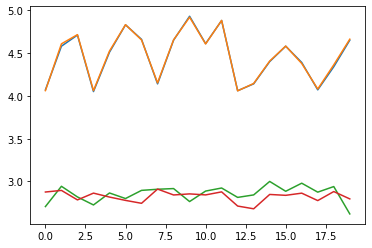

In [96]:
Predirect_arr = np.random.randint(10, size=(20,100, 1))
# print(np.mean(Predirect_arr, axis=1))
# task1MeanModel.predict(Predirect_arr)

plt.plot(range(20),np.mean(Predirect_arr, axis=1),range(20),task1MeanModel.predict(Predirect_arr))
plt.plot(range(20),np.std(Predirect_arr, axis=1),range(20),fin2.predict(Predirect_arr))

# TASK 2

Train two feature imitating networks that take as input an arbitrary length sequence and provide as output (1) the mean and (2) the standard deviation of the sequence; a LSTM, or other recurrent architecture should be sufficient for this.

In [47]:
# Generate random length of array
# T x Ch x Epochs
row = random.randint(80, 120) # Arbitrary length of data
column = 25 # data per group
input_arr = np.random.randint(10, size=(row,column, 1) )

print(input_arr.shape)

(105, 25, 1)


In [48]:
# Target Arr one for Mean, one for Std
target_arr = np.squeeze(Mean(input_arr))
target_arr2 = np.squeeze(STD(input_arr))
print(target_arr.shape)

# the first model for calculate the mean, second model for std, 
# also picked different preset parameters of topology for two models
model = make_FIN(topology,1,column)
model2 = make_FIN(topology,1,column)

# Having the code setting up the parameters here for changes

# learning_rate=topology['lr']
# momentum=topology['momentum']
# nesterov=topology['nesterov']
b1 = topology['b1']
b2 = topology['b2']
# if topology['opt'] == 'SGD':
#     grad_desc_algorithm = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum,nesterov=nesterov)
# if topology['opt'] == 'ADAM':
#     grad_desc_algorithm = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=b1,beta_2=b2)
    
#make LSTM model, make all the nodes sequential first for LSTM reccursive
model = Sequential()
model2 = Sequential()


model.add(LSTM(1,batch_input_shape=(None,column,1 ), activation='relu'))
#model.add(Dense(4,activation='sigmoid'))

model2.add(LSTM(1,batch_input_shape=(None,column,1 ), activation='relu'))

(105,)


In [40]:
# note: use SGD gonna be a lot less accuracy than adam, from testing results
# gonna use adam right now if not fit with Fin's feature will change later
grad_desc_algorithm = tf.keras.optimizers.Adam(learning_rate=0.00000001)
#grad_desc_algorithm = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=momentum,nesterov=nesterov)

# model.compile(loss ='mean_squared_error', optimizer='adam')
#model2.compile(loss ='mean_squared_error', optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [45]:
# In real training I used different aprecciated epochs for them until the loss signficently not decreasing more.

#mean 3K epoches
#std 5K

# model.fit(input_arr, target_arr, 
#             epochs = 500,
#             verbose   = 1)
# model2.fit(input_arr, target_arr2, 
#             epochs = 500,
#             verbose   = 1)

[[5.057742 ]
 [4.159167 ]
 [3.8699615]
 [4.1202273]
 [4.9019384]
 [4.046044 ]
 [4.8431263]
 [5.587432 ]
 [5.20847  ]
 [3.758718 ]
 [4.8584423]
 [4.28686  ]
 [5.120909 ]
 [3.9899988]
 [4.3461637]
 [4.8363724]
 [4.9608564]
 [4.8411756]
 [4.184009 ]
 [4.065522 ]]
4.56
[[2.640481 ]
 [2.790485 ]
 [2.8948843]
 [2.8940187]
 [2.6511173]
 [2.6974034]
 [2.8138726]
 [2.9850838]
 [2.3737056]
 [2.6913023]
 [2.9020057]
 [2.5921524]
 [2.4632826]
 [2.4490027]
 [2.4273615]
 [2.7146974]
 [3.073991 ]
 [2.9666708]
 [2.7625191]
 [3.0253286]]
2.8345017198795275


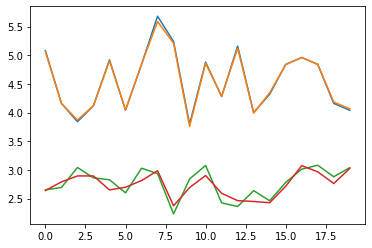

In [14]:
pp_arr = np.random.randint(10, size=(20,25, 1))

# model = load_model('./Models/Modelstask2Mean.h5')
# model2 = load_model('./Models/Modelstask2Std.h5')
print(model.predict(pp_arr))
print(np.mean(pp_arr))

print(model2.predict(pp_arr))
print(np.std(pp_arr))

plt.plot(range(20),np.mean(pp_arr, axis=1),range(20),model.predict(pp_arr))
plt.plot(range(20),np.std(pp_arr, axis=1),range(20),model2.predict(pp_arr))



In [46]:
# save the mean model for task2
#model.save("./Models/Modelstask2Mean.h5")
#model2.save("./Models/Modelstask2Std.h5")

# TASK 3

Train one feature imitating network that takes as input an arbitrary length sequence, and provides both the mean and standard deviation of that sequence; an LSTM or other recurrent architecture with multiple outputs should be sufficient for this task.

In [49]:
# Will use the same input data as Task 2 for Task 3

model_task3 = make_FIN(topology,1,column)

In [50]:
model_task3 = Sequential()
model_task3.add(LSTM(2,batch_input_shape=(None,column,1 ), activation='relu'))
model_task3.compile(loss ='mean_squared_error', optimizer='adam')

In [51]:
feature_output_arr = np.stack([target_arr,target_arr2], axis=1)


# 4000
model_task3.fit(input_arr, feature_output_arr, 
            epochs = 4000,
            verbose   = 2)

Epoch 1/4000
4/4 - 2s - loss: 10.1923
Epoch 2/4000
4/4 - 0s - loss: 9.4649
Epoch 3/4000
4/4 - 0s - loss: 9.0366
Epoch 4/4000
4/4 - 0s - loss: 8.7624
Epoch 5/4000
4/4 - 0s - loss: 8.5496
Epoch 6/4000
4/4 - 1s - loss: 8.4068
Epoch 7/4000
4/4 - 0s - loss: 8.2787
Epoch 8/4000
4/4 - 0s - loss: 8.1393
Epoch 9/4000
4/4 - 0s - loss: 7.9962
Epoch 10/4000
4/4 - 0s - loss: 7.8388
Epoch 11/4000
4/4 - 0s - loss: 7.6698
Epoch 12/4000
4/4 - 0s - loss: 7.4786
Epoch 13/4000
4/4 - 0s - loss: 7.2664
Epoch 14/4000
4/4 - 0s - loss: 7.0363
Epoch 15/4000
4/4 - 0s - loss: 6.7836
Epoch 16/4000
4/4 - 0s - loss: 6.5043
Epoch 17/4000
4/4 - 0s - loss: 6.1957
Epoch 18/4000
4/4 - 0s - loss: 5.8608
Epoch 19/4000
4/4 - 0s - loss: 5.4938
Epoch 20/4000
4/4 - 0s - loss: 5.0945
Epoch 21/4000
4/4 - 0s - loss: 4.6735
Epoch 22/4000
4/4 - 0s - loss: 4.2246
Epoch 23/4000
4/4 - 0s - loss: 3.7396
Epoch 24/4000
4/4 - 0s - loss: 3.2633
Epoch 25/4000
4/4 - 0s - loss: 2.7667
Epoch 26/4000
4/4 - 0s - loss: 2.3037
Epoch 27/4000
4/4 - 

Epoch 214/4000
4/4 - 0s - loss: 0.1736
Epoch 215/4000
4/4 - 0s - loss: 0.1724
Epoch 216/4000
4/4 - 0s - loss: 0.1716
Epoch 217/4000
4/4 - 0s - loss: 0.1707
Epoch 218/4000
4/4 - 0s - loss: 0.1700
Epoch 219/4000
4/4 - 0s - loss: 0.1693
Epoch 220/4000
4/4 - 0s - loss: 0.1681
Epoch 221/4000
4/4 - 0s - loss: 0.1669
Epoch 222/4000
4/4 - 0s - loss: 0.1659
Epoch 223/4000
4/4 - 0s - loss: 0.1664
Epoch 224/4000
4/4 - 0s - loss: 0.1653
Epoch 225/4000
4/4 - 0s - loss: 0.1640
Epoch 226/4000
4/4 - 0s - loss: 0.1624
Epoch 227/4000
4/4 - 0s - loss: 0.1622
Epoch 228/4000
4/4 - 0s - loss: 0.1611
Epoch 229/4000
4/4 - 0s - loss: 0.1601
Epoch 230/4000
4/4 - 0s - loss: 0.1600
Epoch 231/4000
4/4 - 0s - loss: 0.1591
Epoch 232/4000
4/4 - 0s - loss: 0.1579
Epoch 233/4000
4/4 - 0s - loss: 0.1574
Epoch 234/4000
4/4 - 0s - loss: 0.1567
Epoch 235/4000
4/4 - 0s - loss: 0.1557
Epoch 236/4000
4/4 - 0s - loss: 0.1545
Epoch 237/4000
4/4 - 0s - loss: 0.1538
Epoch 238/4000
4/4 - 0s - loss: 0.1530
Epoch 239/4000
4/4 - 0s -

4/4 - 0s - loss: 0.0913
Epoch 425/4000
4/4 - 0s - loss: 0.0914
Epoch 426/4000
4/4 - 0s - loss: 0.0911
Epoch 427/4000
4/4 - 0s - loss: 0.0911
Epoch 428/4000
4/4 - 0s - loss: 0.0909
Epoch 429/4000
4/4 - 0s - loss: 0.0903
Epoch 430/4000
4/4 - 0s - loss: 0.0916
Epoch 431/4000
4/4 - 0s - loss: 0.0915
Epoch 432/4000
4/4 - 1s - loss: 0.0908
Epoch 433/4000
4/4 - 0s - loss: 0.0902
Epoch 434/4000
4/4 - 0s - loss: 0.0898
Epoch 435/4000
4/4 - 0s - loss: 0.0898
Epoch 436/4000
4/4 - 0s - loss: 0.0897
Epoch 437/4000
4/4 - 0s - loss: 0.0896
Epoch 438/4000
4/4 - 0s - loss: 0.0894
Epoch 439/4000
4/4 - 0s - loss: 0.0896
Epoch 440/4000
4/4 - 0s - loss: 0.0893
Epoch 441/4000
4/4 - 0s - loss: 0.0894
Epoch 442/4000
4/4 - 0s - loss: 0.0893
Epoch 443/4000
4/4 - 0s - loss: 0.0892
Epoch 444/4000
4/4 - 0s - loss: 0.0888
Epoch 445/4000
4/4 - 0s - loss: 0.0884
Epoch 446/4000
4/4 - 1s - loss: 0.0884
Epoch 447/4000
4/4 - 0s - loss: 0.0884
Epoch 448/4000
4/4 - 0s - loss: 0.0883
Epoch 449/4000
4/4 - 0s - loss: 0.0882
E

Epoch 635/4000
4/4 - 0s - loss: 0.0765
Epoch 636/4000
4/4 - 0s - loss: 0.0766
Epoch 637/4000
4/4 - 0s - loss: 0.0765
Epoch 638/4000
4/4 - 0s - loss: 0.0763
Epoch 639/4000
4/4 - 0s - loss: 0.0761
Epoch 640/4000
4/4 - 0s - loss: 0.0761
Epoch 641/4000
4/4 - 0s - loss: 0.0765
Epoch 642/4000
4/4 - 0s - loss: 0.0765
Epoch 643/4000
4/4 - 0s - loss: 0.0763
Epoch 644/4000
4/4 - 0s - loss: 0.0762
Epoch 645/4000
4/4 - 0s - loss: 0.0761
Epoch 646/4000
4/4 - 0s - loss: 0.0760
Epoch 647/4000
4/4 - 0s - loss: 0.0759
Epoch 648/4000
4/4 - 0s - loss: 0.0760
Epoch 649/4000
4/4 - 0s - loss: 0.0760
Epoch 650/4000
4/4 - 0s - loss: 0.0761
Epoch 651/4000
4/4 - 0s - loss: 0.0758
Epoch 652/4000
4/4 - 0s - loss: 0.0761
Epoch 653/4000
4/4 - 0s - loss: 0.0762
Epoch 654/4000
4/4 - 0s - loss: 0.0760
Epoch 655/4000
4/4 - 0s - loss: 0.0757
Epoch 656/4000
4/4 - 0s - loss: 0.0760
Epoch 657/4000
4/4 - 0s - loss: 0.0759
Epoch 658/4000
4/4 - 0s - loss: 0.0759
Epoch 659/4000
4/4 - 0s - loss: 0.0760
Epoch 660/4000
4/4 - 0s -

4/4 - 0s - loss: 0.0695
Epoch 846/4000
4/4 - 0s - loss: 0.0687
Epoch 847/4000
4/4 - 0s - loss: 0.0695
Epoch 848/4000
4/4 - 0s - loss: 0.0693
Epoch 849/4000
4/4 - 0s - loss: 0.0689
Epoch 850/4000
4/4 - 0s - loss: 0.0691
Epoch 851/4000
4/4 - 0s - loss: 0.0691
Epoch 852/4000
4/4 - 0s - loss: 0.0687
Epoch 853/4000
4/4 - 0s - loss: 0.0684
Epoch 854/4000
4/4 - 0s - loss: 0.0687
Epoch 855/4000
4/4 - 0s - loss: 0.0684
Epoch 856/4000
4/4 - 0s - loss: 0.0687
Epoch 857/4000
4/4 - 0s - loss: 0.0691
Epoch 858/4000
4/4 - 0s - loss: 0.0686
Epoch 859/4000
4/4 - 0s - loss: 0.0684
Epoch 860/4000
4/4 - 0s - loss: 0.0683
Epoch 861/4000
4/4 - 0s - loss: 0.0682
Epoch 862/4000
4/4 - 0s - loss: 0.0682
Epoch 863/4000
4/4 - 0s - loss: 0.0681
Epoch 864/4000
4/4 - 0s - loss: 0.0687
Epoch 865/4000
4/4 - 0s - loss: 0.0683
Epoch 866/4000
4/4 - 0s - loss: 0.0681
Epoch 867/4000
4/4 - 0s - loss: 0.0686
Epoch 868/4000
4/4 - 0s - loss: 0.0692
Epoch 869/4000
4/4 - 0s - loss: 0.0682
Epoch 870/4000
4/4 - 0s - loss: 0.0679
E

4/4 - 0s - loss: 0.0596
Epoch 1055/4000
4/4 - 0s - loss: 0.0591
Epoch 1056/4000
4/4 - 0s - loss: 0.0591
Epoch 1057/4000
4/4 - 0s - loss: 0.0597
Epoch 1058/4000
4/4 - 0s - loss: 0.0594
Epoch 1059/4000
4/4 - 0s - loss: 0.0591
Epoch 1060/4000
4/4 - 0s - loss: 0.0588
Epoch 1061/4000
4/4 - 0s - loss: 0.0588
Epoch 1062/4000
4/4 - 0s - loss: 0.0592
Epoch 1063/4000
4/4 - 0s - loss: 0.0590
Epoch 1064/4000
4/4 - 0s - loss: 0.0589
Epoch 1065/4000
4/4 - 0s - loss: 0.0593
Epoch 1066/4000
4/4 - 0s - loss: 0.0598
Epoch 1067/4000
4/4 - 0s - loss: 0.0591
Epoch 1068/4000
4/4 - 0s - loss: 0.0609
Epoch 1069/4000
4/4 - 0s - loss: 0.0582
Epoch 1070/4000
4/4 - 0s - loss: 0.0583
Epoch 1071/4000
4/4 - 0s - loss: 0.0602
Epoch 1072/4000
4/4 - 0s - loss: 0.0575
Epoch 1073/4000
4/4 - 0s - loss: 0.0596
Epoch 1074/4000
4/4 - 0s - loss: 0.0594
Epoch 1075/4000
4/4 - 0s - loss: 0.0586
Epoch 1076/4000
4/4 - 0s - loss: 0.0583
Epoch 1077/4000
4/4 - 0s - loss: 0.0582
Epoch 1078/4000
4/4 - 0s - loss: 0.0601
Epoch 1079/4000


4/4 - 0s - loss: 0.0491
Epoch 1260/4000
4/4 - 0s - loss: 0.0496
Epoch 1261/4000
4/4 - 0s - loss: 0.0500
Epoch 1262/4000
4/4 - 0s - loss: 0.0494
Epoch 1263/4000
4/4 - 0s - loss: 0.0489
Epoch 1264/4000
4/4 - 0s - loss: 0.0495
Epoch 1265/4000
4/4 - 0s - loss: 0.0488
Epoch 1266/4000
4/4 - 0s - loss: 0.0491
Epoch 1267/4000
4/4 - 0s - loss: 0.0504
Epoch 1268/4000
4/4 - 0s - loss: 0.0495
Epoch 1269/4000
4/4 - 0s - loss: 0.0491
Epoch 1270/4000
4/4 - 0s - loss: 0.0495
Epoch 1271/4000
4/4 - 0s - loss: 0.0488
Epoch 1272/4000
4/4 - 0s - loss: 0.0491
Epoch 1273/4000
4/4 - 0s - loss: 0.0484
Epoch 1274/4000
4/4 - 0s - loss: 0.0486
Epoch 1275/4000
4/4 - 0s - loss: 0.0484
Epoch 1276/4000
4/4 - 0s - loss: 0.0482
Epoch 1277/4000
4/4 - 0s - loss: 0.0485
Epoch 1278/4000
4/4 - 0s - loss: 0.0487
Epoch 1279/4000
4/4 - 0s - loss: 0.0482
Epoch 1280/4000
4/4 - 0s - loss: 0.0483
Epoch 1281/4000
4/4 - 0s - loss: 0.0494
Epoch 1282/4000
4/4 - 0s - loss: 0.0481
Epoch 1283/4000
4/4 - 0s - loss: 0.0487
Epoch 1284/4000


Epoch 1465/4000
4/4 - 0s - loss: 0.0473
Epoch 1466/4000
4/4 - 0s - loss: 0.0459
Epoch 1467/4000
4/4 - 0s - loss: 0.0439
Epoch 1468/4000
4/4 - 0s - loss: 0.0441
Epoch 1469/4000
4/4 - 0s - loss: 0.0442
Epoch 1470/4000
4/4 - 0s - loss: 0.0430
Epoch 1471/4000
4/4 - 0s - loss: 0.0440
Epoch 1472/4000
4/4 - 0s - loss: 0.0422
Epoch 1473/4000
4/4 - 0s - loss: 0.0420
Epoch 1474/4000
4/4 - 0s - loss: 0.0433
Epoch 1475/4000
4/4 - 0s - loss: 0.0424
Epoch 1476/4000
4/4 - 0s - loss: 0.0419
Epoch 1477/4000
4/4 - 0s - loss: 0.0418
Epoch 1478/4000
4/4 - 0s - loss: 0.0422
Epoch 1479/4000
4/4 - 0s - loss: 0.0422
Epoch 1480/4000
4/4 - 0s - loss: 0.0421
Epoch 1481/4000
4/4 - 0s - loss: 0.0426
Epoch 1482/4000
4/4 - 0s - loss: 0.0420
Epoch 1483/4000
4/4 - 0s - loss: 0.0423
Epoch 1484/4000
4/4 - 0s - loss: 0.0420
Epoch 1485/4000
4/4 - 0s - loss: 0.0427
Epoch 1486/4000
4/4 - 0s - loss: 0.0430
Epoch 1487/4000
4/4 - 0s - loss: 0.0442
Epoch 1488/4000
4/4 - 0s - loss: 0.0417
Epoch 1489/4000
4/4 - 0s - loss: 0.0420


Epoch 1670/4000
4/4 - 0s - loss: 0.0373
Epoch 1671/4000
4/4 - 0s - loss: 0.0374
Epoch 1672/4000
4/4 - 0s - loss: 0.0371
Epoch 1673/4000
4/4 - 0s - loss: 0.0370
Epoch 1674/4000
4/4 - 0s - loss: 0.0371
Epoch 1675/4000
4/4 - 0s - loss: 0.0371
Epoch 1676/4000
4/4 - 0s - loss: 0.0373
Epoch 1677/4000
4/4 - 0s - loss: 0.0367
Epoch 1678/4000
4/4 - 0s - loss: 0.0371
Epoch 1679/4000
4/4 - 0s - loss: 0.0366
Epoch 1680/4000
4/4 - 0s - loss: 0.0377
Epoch 1681/4000
4/4 - 0s - loss: 0.0370
Epoch 1682/4000
4/4 - 0s - loss: 0.0366
Epoch 1683/4000
4/4 - 0s - loss: 0.0370
Epoch 1684/4000
4/4 - 0s - loss: 0.0384
Epoch 1685/4000
4/4 - 0s - loss: 0.0364
Epoch 1686/4000
4/4 - 0s - loss: 0.0382
Epoch 1687/4000
4/4 - 0s - loss: 0.0416
Epoch 1688/4000
4/4 - 0s - loss: 0.0388
Epoch 1689/4000
4/4 - 0s - loss: 0.0384
Epoch 1690/4000
4/4 - 0s - loss: 0.0382
Epoch 1691/4000
4/4 - 0s - loss: 0.0365
Epoch 1692/4000
4/4 - 0s - loss: 0.0361
Epoch 1693/4000
4/4 - 0s - loss: 0.0366
Epoch 1694/4000
4/4 - 0s - loss: 0.0368


Epoch 1875/4000
4/4 - 0s - loss: 0.0319
Epoch 1876/4000
4/4 - 0s - loss: 0.0333
Epoch 1877/4000
4/4 - 0s - loss: 0.0335
Epoch 1878/4000
4/4 - 0s - loss: 0.0330
Epoch 1879/4000
4/4 - 0s - loss: 0.0336
Epoch 1880/4000
4/4 - 0s - loss: 0.0338
Epoch 1881/4000
4/4 - 0s - loss: 0.0332
Epoch 1882/4000
4/4 - 0s - loss: 0.0339
Epoch 1883/4000
4/4 - 0s - loss: 0.0370
Epoch 1884/4000
4/4 - 0s - loss: 0.0362
Epoch 1885/4000
4/4 - 0s - loss: 0.0329
Epoch 1886/4000
4/4 - 0s - loss: 0.0346
Epoch 1887/4000
4/4 - 0s - loss: 0.0352
Epoch 1888/4000
4/4 - 0s - loss: 0.0321
Epoch 1889/4000
4/4 - 0s - loss: 0.0323
Epoch 1890/4000
4/4 - 0s - loss: 0.0320
Epoch 1891/4000
4/4 - 0s - loss: 0.0323
Epoch 1892/4000
4/4 - 0s - loss: 0.0348
Epoch 1893/4000
4/4 - 0s - loss: 0.0321
Epoch 1894/4000
4/4 - 0s - loss: 0.0318
Epoch 1895/4000
4/4 - 0s - loss: 0.0341
Epoch 1896/4000
4/4 - 0s - loss: 0.0377
Epoch 1897/4000
4/4 - 0s - loss: 0.0348
Epoch 1898/4000
4/4 - 0s - loss: 0.0337
Epoch 1899/4000
4/4 - 0s - loss: 0.0352


Epoch 2080/4000
4/4 - 0s - loss: 0.0290
Epoch 2081/4000
4/4 - 0s - loss: 0.0292
Epoch 2082/4000
4/4 - 0s - loss: 0.0286
Epoch 2083/4000
4/4 - 0s - loss: 0.0289
Epoch 2084/4000
4/4 - 0s - loss: 0.0289
Epoch 2085/4000
4/4 - 0s - loss: 0.0285
Epoch 2086/4000
4/4 - 0s - loss: 0.0284
Epoch 2087/4000
4/4 - 0s - loss: 0.0280
Epoch 2088/4000
4/4 - 0s - loss: 0.0282
Epoch 2089/4000
4/4 - 0s - loss: 0.0278
Epoch 2090/4000
4/4 - 0s - loss: 0.0283
Epoch 2091/4000
4/4 - 0s - loss: 0.0279
Epoch 2092/4000
4/4 - 0s - loss: 0.0296
Epoch 2093/4000
4/4 - 0s - loss: 0.0313
Epoch 2094/4000
4/4 - 0s - loss: 0.0294
Epoch 2095/4000
4/4 - 0s - loss: 0.0285
Epoch 2096/4000
4/4 - 0s - loss: 0.0287
Epoch 2097/4000
4/4 - 0s - loss: 0.0297
Epoch 2098/4000
4/4 - 0s - loss: 0.0297
Epoch 2099/4000
4/4 - 0s - loss: 0.0287
Epoch 2100/4000
4/4 - 0s - loss: 0.0290
Epoch 2101/4000
4/4 - 0s - loss: 0.0277
Epoch 2102/4000
4/4 - 0s - loss: 0.0282
Epoch 2103/4000
4/4 - 0s - loss: 0.0287
Epoch 2104/4000
4/4 - 0s - loss: 0.0280


Epoch 2285/4000
4/4 - 0s - loss: 0.0333
Epoch 2286/4000
4/4 - 0s - loss: 0.0295
Epoch 2287/4000
4/4 - 0s - loss: 0.0278
Epoch 2288/4000
4/4 - 0s - loss: 0.0261
Epoch 2289/4000
4/4 - 0s - loss: 0.0256
Epoch 2290/4000
4/4 - 0s - loss: 0.0263
Epoch 2291/4000
4/4 - 0s - loss: 0.0262
Epoch 2292/4000
4/4 - 0s - loss: 0.0257
Epoch 2293/4000
4/4 - 0s - loss: 0.0262
Epoch 2294/4000
4/4 - 0s - loss: 0.0277
Epoch 2295/4000
4/4 - 0s - loss: 0.0259
Epoch 2296/4000
4/4 - 0s - loss: 0.0258
Epoch 2297/4000
4/4 - 0s - loss: 0.0259
Epoch 2298/4000
4/4 - 0s - loss: 0.0275
Epoch 2299/4000
4/4 - 0s - loss: 0.0259
Epoch 2300/4000
4/4 - 0s - loss: 0.0257
Epoch 2301/4000
4/4 - 0s - loss: 0.0259
Epoch 2302/4000
4/4 - 0s - loss: 0.0253
Epoch 2303/4000
4/4 - 0s - loss: 0.0257
Epoch 2304/4000
4/4 - 0s - loss: 0.0267
Epoch 2305/4000
4/4 - 0s - loss: 0.0265
Epoch 2306/4000
4/4 - 0s - loss: 0.0270
Epoch 2307/4000
4/4 - 0s - loss: 0.0283
Epoch 2308/4000
4/4 - 0s - loss: 0.0305
Epoch 2309/4000
4/4 - 0s - loss: 0.0291


Epoch 2490/4000
4/4 - 0s - loss: 0.0241
Epoch 2491/4000
4/4 - 0s - loss: 0.0238
Epoch 2492/4000
4/4 - 0s - loss: 0.0237
Epoch 2493/4000
4/4 - 0s - loss: 0.0235
Epoch 2494/4000
4/4 - 0s - loss: 0.0236
Epoch 2495/4000
4/4 - 0s - loss: 0.0242
Epoch 2496/4000
4/4 - 0s - loss: 0.0237
Epoch 2497/4000
4/4 - 0s - loss: 0.0237
Epoch 2498/4000
4/4 - 0s - loss: 0.0241
Epoch 2499/4000
4/4 - 0s - loss: 0.0240
Epoch 2500/4000
4/4 - 0s - loss: 0.0235
Epoch 2501/4000
4/4 - 0s - loss: 0.0245
Epoch 2502/4000
4/4 - 0s - loss: 0.0245
Epoch 2503/4000
4/4 - 0s - loss: 0.0240
Epoch 2504/4000
4/4 - 0s - loss: 0.0245
Epoch 2505/4000
4/4 - 0s - loss: 0.0252
Epoch 2506/4000
4/4 - 0s - loss: 0.0262
Epoch 2507/4000
4/4 - 0s - loss: 0.0238
Epoch 2508/4000
4/4 - 0s - loss: 0.0237
Epoch 2509/4000
4/4 - 0s - loss: 0.0236
Epoch 2510/4000
4/4 - 0s - loss: 0.0233
Epoch 2511/4000
4/4 - 0s - loss: 0.0238
Epoch 2512/4000
4/4 - 0s - loss: 0.0251
Epoch 2513/4000
4/4 - 0s - loss: 0.0234
Epoch 2514/4000
4/4 - 0s - loss: 0.0245


Epoch 2695/4000
4/4 - 0s - loss: 0.0231
Epoch 2696/4000
4/4 - 0s - loss: 0.0249
Epoch 2697/4000
4/4 - 0s - loss: 0.0260
Epoch 2698/4000
4/4 - 0s - loss: 0.0242
Epoch 2699/4000
4/4 - 0s - loss: 0.0242
Epoch 2700/4000
4/4 - 0s - loss: 0.0242
Epoch 2701/4000
4/4 - 0s - loss: 0.0243
Epoch 2702/4000
4/4 - 0s - loss: 0.0224
Epoch 2703/4000
4/4 - 0s - loss: 0.0225
Epoch 2704/4000
4/4 - 0s - loss: 0.0221
Epoch 2705/4000
4/4 - 0s - loss: 0.0234
Epoch 2706/4000
4/4 - 0s - loss: 0.0224
Epoch 2707/4000
4/4 - 0s - loss: 0.0222
Epoch 2708/4000
4/4 - 0s - loss: 0.0225
Epoch 2709/4000
4/4 - 0s - loss: 0.0229
Epoch 2710/4000
4/4 - 0s - loss: 0.0230
Epoch 2711/4000
4/4 - 0s - loss: 0.0225
Epoch 2712/4000
4/4 - 0s - loss: 0.0228
Epoch 2713/4000
4/4 - 0s - loss: 0.0230
Epoch 2714/4000
4/4 - 0s - loss: 0.0226
Epoch 2715/4000
4/4 - 0s - loss: 0.0234
Epoch 2716/4000
4/4 - 0s - loss: 0.0225
Epoch 2717/4000
4/4 - 0s - loss: 0.0221
Epoch 2718/4000
4/4 - 0s - loss: 0.0231
Epoch 2719/4000
4/4 - 0s - loss: 0.0232


Epoch 2900/4000
4/4 - 0s - loss: 0.0213
Epoch 2901/4000
4/4 - 0s - loss: 0.0224
Epoch 2902/4000
4/4 - 0s - loss: 0.0224
Epoch 2903/4000
4/4 - 0s - loss: 0.0214
Epoch 2904/4000
4/4 - 0s - loss: 0.0216
Epoch 2905/4000
4/4 - 0s - loss: 0.0246
Epoch 2906/4000
4/4 - 0s - loss: 0.0235
Epoch 2907/4000
4/4 - 0s - loss: 0.0222
Epoch 2908/4000
4/4 - 0s - loss: 0.0223
Epoch 2909/4000
4/4 - 0s - loss: 0.0229
Epoch 2910/4000
4/4 - 0s - loss: 0.0242
Epoch 2911/4000
4/4 - 0s - loss: 0.0217
Epoch 2912/4000
4/4 - 0s - loss: 0.0229
Epoch 2913/4000
4/4 - 0s - loss: 0.0227
Epoch 2914/4000
4/4 - 0s - loss: 0.0223
Epoch 2915/4000
4/4 - 0s - loss: 0.0228
Epoch 2916/4000
4/4 - 0s - loss: 0.0241
Epoch 2917/4000
4/4 - 0s - loss: 0.0246
Epoch 2918/4000
4/4 - 0s - loss: 0.0232
Epoch 2919/4000
4/4 - 0s - loss: 0.0226
Epoch 2920/4000
4/4 - 0s - loss: 0.0214
Epoch 2921/4000
4/4 - 0s - loss: 0.0223
Epoch 2922/4000
4/4 - 0s - loss: 0.0215
Epoch 2923/4000
4/4 - 0s - loss: 0.0215
Epoch 2924/4000
4/4 - 0s - loss: 0.0222


Epoch 3105/4000
4/4 - 0s - loss: 0.0242
Epoch 3106/4000
4/4 - 0s - loss: 0.0228
Epoch 3107/4000
4/4 - 0s - loss: 0.0226
Epoch 3108/4000
4/4 - 0s - loss: 0.0213
Epoch 3109/4000
4/4 - 0s - loss: 0.0218
Epoch 3110/4000
4/4 - 0s - loss: 0.0213
Epoch 3111/4000
4/4 - 0s - loss: 0.0206
Epoch 3112/4000
4/4 - 0s - loss: 0.0208
Epoch 3113/4000
4/4 - 0s - loss: 0.0204
Epoch 3114/4000
4/4 - 0s - loss: 0.0205
Epoch 3115/4000
4/4 - 0s - loss: 0.0205
Epoch 3116/4000
4/4 - 0s - loss: 0.0205
Epoch 3117/4000
4/4 - 0s - loss: 0.0204
Epoch 3118/4000
4/4 - 0s - loss: 0.0215
Epoch 3119/4000
4/4 - 0s - loss: 0.0204
Epoch 3120/4000
4/4 - 0s - loss: 0.0208
Epoch 3121/4000
4/4 - 0s - loss: 0.0209
Epoch 3122/4000
4/4 - 0s - loss: 0.0205
Epoch 3123/4000
4/4 - 0s - loss: 0.0208
Epoch 3124/4000
4/4 - 0s - loss: 0.0205
Epoch 3125/4000
4/4 - 0s - loss: 0.0204
Epoch 3126/4000
4/4 - 0s - loss: 0.0205
Epoch 3127/4000
4/4 - 0s - loss: 0.0208
Epoch 3128/4000
4/4 - 0s - loss: 0.0208
Epoch 3129/4000
4/4 - 0s - loss: 0.0238


Epoch 3310/4000
4/4 - 0s - loss: 0.0208
Epoch 3311/4000
4/4 - 0s - loss: 0.0215
Epoch 3312/4000
4/4 - 0s - loss: 0.0199
Epoch 3313/4000
4/4 - 0s - loss: 0.0209
Epoch 3314/4000
4/4 - 0s - loss: 0.0203
Epoch 3315/4000
4/4 - 0s - loss: 0.0199
Epoch 3316/4000
4/4 - 0s - loss: 0.0201
Epoch 3317/4000
4/4 - 0s - loss: 0.0209
Epoch 3318/4000
4/4 - 0s - loss: 0.0204
Epoch 3319/4000
4/4 - 0s - loss: 0.0210
Epoch 3320/4000
4/4 - 0s - loss: 0.0213
Epoch 3321/4000
4/4 - 0s - loss: 0.0204
Epoch 3322/4000
4/4 - 0s - loss: 0.0208
Epoch 3323/4000
4/4 - 0s - loss: 0.0202
Epoch 3324/4000
4/4 - 0s - loss: 0.0206
Epoch 3325/4000
4/4 - 0s - loss: 0.0198
Epoch 3326/4000
4/4 - 0s - loss: 0.0199
Epoch 3327/4000
4/4 - 0s - loss: 0.0200
Epoch 3328/4000
4/4 - 0s - loss: 0.0198
Epoch 3329/4000
4/4 - 0s - loss: 0.0199
Epoch 3330/4000
4/4 - 0s - loss: 0.0197
Epoch 3331/4000
4/4 - 0s - loss: 0.0196
Epoch 3332/4000
4/4 - 0s - loss: 0.0199
Epoch 3333/4000
4/4 - 0s - loss: 0.0199
Epoch 3334/4000
4/4 - 0s - loss: 0.0201


Epoch 3515/4000
4/4 - 0s - loss: 0.0206
Epoch 3516/4000
4/4 - 0s - loss: 0.0196
Epoch 3517/4000
4/4 - 0s - loss: 0.0202
Epoch 3518/4000
4/4 - 0s - loss: 0.0238
Epoch 3519/4000
4/4 - 0s - loss: 0.0200
Epoch 3520/4000
4/4 - 0s - loss: 0.0199
Epoch 3521/4000
4/4 - 0s - loss: 0.0193
Epoch 3522/4000
4/4 - 0s - loss: 0.0200
Epoch 3523/4000
4/4 - 0s - loss: 0.0200
Epoch 3524/4000
4/4 - 0s - loss: 0.0202
Epoch 3525/4000
4/4 - 0s - loss: 0.0194
Epoch 3526/4000
4/4 - 0s - loss: 0.0195
Epoch 3527/4000
4/4 - 0s - loss: 0.0193
Epoch 3528/4000
4/4 - 0s - loss: 0.0192
Epoch 3529/4000
4/4 - 0s - loss: 0.0227
Epoch 3530/4000
4/4 - 0s - loss: 0.0205
Epoch 3531/4000
4/4 - 0s - loss: 0.0200
Epoch 3532/4000
4/4 - 0s - loss: 0.0197
Epoch 3533/4000
4/4 - 0s - loss: 0.0193
Epoch 3534/4000
4/4 - 0s - loss: 0.0189
Epoch 3535/4000
4/4 - 0s - loss: 0.0192
Epoch 3536/4000
4/4 - 0s - loss: 0.0195
Epoch 3537/4000
4/4 - 0s - loss: 0.0193
Epoch 3538/4000
4/4 - 0s - loss: 0.0197
Epoch 3539/4000
4/4 - 0s - loss: 0.0200


Epoch 3720/4000
4/4 - 0s - loss: 0.0241
Epoch 3721/4000
4/4 - 0s - loss: 0.0195
Epoch 3722/4000
4/4 - 0s - loss: 0.0195
Epoch 3723/4000
4/4 - 0s - loss: 0.0200
Epoch 3724/4000
4/4 - 0s - loss: 0.0218
Epoch 3725/4000
4/4 - 0s - loss: 0.0202
Epoch 3726/4000
4/4 - 0s - loss: 0.0206
Epoch 3727/4000
4/4 - 0s - loss: 0.0192
Epoch 3728/4000
4/4 - 0s - loss: 0.0187
Epoch 3729/4000
4/4 - 0s - loss: 0.0189
Epoch 3730/4000
4/4 - 0s - loss: 0.0196
Epoch 3731/4000
4/4 - 0s - loss: 0.0194
Epoch 3732/4000
4/4 - 0s - loss: 0.0207
Epoch 3733/4000
4/4 - 0s - loss: 0.0205
Epoch 3734/4000
4/4 - 0s - loss: 0.0214
Epoch 3735/4000
4/4 - 0s - loss: 0.0202
Epoch 3736/4000
4/4 - 0s - loss: 0.0196
Epoch 3737/4000
4/4 - 0s - loss: 0.0189
Epoch 3738/4000
4/4 - 0s - loss: 0.0191
Epoch 3739/4000
4/4 - 0s - loss: 0.0201
Epoch 3740/4000
4/4 - 0s - loss: 0.0206
Epoch 3741/4000
4/4 - 0s - loss: 0.0188
Epoch 3742/4000
4/4 - 0s - loss: 0.0187
Epoch 3743/4000
4/4 - 0s - loss: 0.0188
Epoch 3744/4000
4/4 - 0s - loss: 0.0191


Epoch 3925/4000
4/4 - 0s - loss: 0.0190
Epoch 3926/4000
4/4 - 0s - loss: 0.0185
Epoch 3927/4000
4/4 - 0s - loss: 0.0184
Epoch 3928/4000
4/4 - 0s - loss: 0.0182
Epoch 3929/4000
4/4 - 0s - loss: 0.0181
Epoch 3930/4000
4/4 - 0s - loss: 0.0187
Epoch 3931/4000
4/4 - 0s - loss: 0.0202
Epoch 3932/4000
4/4 - 0s - loss: 0.0191
Epoch 3933/4000
4/4 - 0s - loss: 0.0184
Epoch 3934/4000
4/4 - 0s - loss: 0.0193
Epoch 3935/4000
4/4 - 0s - loss: 0.0209
Epoch 3936/4000
4/4 - 0s - loss: 0.0189
Epoch 3937/4000
4/4 - 0s - loss: 0.0180
Epoch 3938/4000
4/4 - 0s - loss: 0.0182
Epoch 3939/4000
4/4 - 0s - loss: 0.0186
Epoch 3940/4000
4/4 - 0s - loss: 0.0182
Epoch 3941/4000
4/4 - 0s - loss: 0.0182
Epoch 3942/4000
4/4 - 0s - loss: 0.0183
Epoch 3943/4000
4/4 - 0s - loss: 0.0182
Epoch 3944/4000
4/4 - 0s - loss: 0.0190
Epoch 3945/4000
4/4 - 0s - loss: 0.0195
Epoch 3946/4000
4/4 - 0s - loss: 0.0192
Epoch 3947/4000
4/4 - 0s - loss: 0.0188
Epoch 3948/4000
4/4 - 0s - loss: 0.0187
Epoch 3949/4000
4/4 - 0s - loss: 0.0187


4.396
2.83111002965268


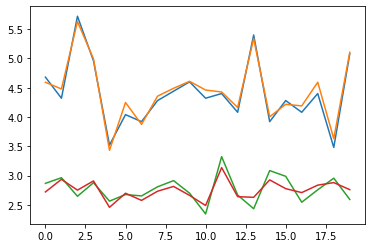

In [54]:
model_task3 = load_model('./Models/Modelstask3.h5')
pp_arr = np.random.randint(10, size=(20,25, 1))
print(np.mean(pp_arr))
print(np.std(pp_arr))
model_task3.predict(pp_arr)
# could compare with task 2 result after loading the model

plt.plot(range(20),np.mean(pp_arr, axis=1),range(20),model_task3.predict(pp_arr).T[0])
plt.plot(range(20),np.std(pp_arr, axis=1),range(20),model_task3.predict(pp_arr).T[1])


In [53]:
#save the model
model_task3.save("./Models/Modelstask3.h5")